# Inference Archival LINKQA

In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, HTML
import sys
import os
from os import path

sys.path.append("./../src")
tmp_path = path.join('.cache', '2023-04-04')
os.makedirs(tmp_path,exist_ok=True)

In [2]:
#SERVER_DIR = '/Users/dunguyen/Projects/IGRIDA/RUNS'
SERVER_DIR = '/srv/tempdd/dunguyen/RUNS'
LOG_PATH = path.join(SERVER_DIR, 'logs')
DATA_CACHE = path.join(SERVER_DIR, 'dataset')
MODEL_CACHE = path.join(SERVER_DIR, 'models')

MONGO_CACHE = path.join(DATA_CACHE, 'archival', 'mongo_db') # Generated from Mongodb
AUTOGESTION_CACHE = path.join(DATA_CACHE, 'archival', 'autogestion') # generated from autogestion repository
INFERENCE_CACHE = path.join(DATA_CACHE, 'archival', 'inference') # model generation

In [3]:
from modules.logger import init_logging
from modules.logger import log

init_logging(color=True)

In [4]:
# CHECK GPU hardware

!nvidia-smi

Fri Apr 14 14:16:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA RTX A5000    Off  | 00000000:3B:00.0 Off |                  Off |
| 30%   29C    P8    20W / 230W |   7505MiB / 24256MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Prepare data cache and stuff

In [8]:
from data_module.archival_module import ArchivalNLIDM
from model_module.lstm.archival_lstm_module import ArchivalLstmModule
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

###############
# PREPARE DATA
###############
dm = ArchivalNLIDM(cache_path=DATA_CACHE, batch_size=16, num_workers=8, version='v1')
dm.prepare_data()
dm.setup('test')

###############
# MODEL MODULE
###############

# model's parameters (could be changed in other versions)
MODEL_NAME = 'v1/run=6_vector=0_lentropy=0.01'
m_kwargs = dict(
    n_context=1, 
    d_embedding=300
)

# leave the default ones
model = ArchivalLstmModule(cache_path=MODEL_CACHE,
    mode='dev',
    vocab=dm.vocab,
    concat_context=True,
    data='archival',
    num_class=dm.num_class, **m_kwargs)

ckpt_path = path.join(LOG_PATH, 'archival', MODEL_NAME, 'checkpoints', 'best.ckpt')
if torch.cuda.is_available():
    checkpoint = torch.load(ckpt_path)
else:
    checkpoint = torch.load(ckpt_path, map_location=torch.device('cpu'))
    
model.to(device)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

print('Model is in cuda: ',next(model.parameters()).is_cuda)

14-04-2023 14:18:08 |     INFO   archival_module.py:prepare_data:102  Loaded vocab at /srv/tempdd/dunguyen/RUNS/dataset/archival/v1/vocab.pt
14-04-2023 14:18:08 |     INFO   archival_module.py:prepare_data:104  Vocab size: 12639
14-04-2023 14:18:08 |     INFO   dataset.py:__init__:87  Load dataset from /srv/tempdd/dunguyen/RUNS/dataset/archival/v1/test.json
14-04-2023 14:18:08 |    DEBUG   dual_lstm_attention.py:__init__:33  Initialize embedding from random
Model is in cuda:  True


### Test model with pytorch lightning trainer

In [10]:
import pytorch_lightning as pl

LOG_DIR = path.join(LOG_PATH, 'archival', MODEL_NAME)
ckpt_path = path.join(LOG_DIR, 'checkpoints', 'best.ckpt')
hparams_path = path.join(LOG_DIR, 'hparams.yaml')

model = ArchivalLstmModule.load_from_checkpoint(
    checkpoint_path='/srv/tempdd/dunguyen/RUNS/logs/archival/'+MODEL_NAME+'/checkpoints/best.ckpt',
    hparams_file='/srv/tempdd/dunguyen/RUNS/logs/archival/'+MODEL_NAME+'/hparams.yaml',
    cache_path='/srv/tempdd/dunguyen/RUNS/models',
    mode='dev',
    vocab=dm.vocab,
    d_embedding=300,
    n_context=1, 
    num_class=2,
    d_fc_out=300,
    n_class=2,
)

trainer = pl.Trainer(
    max_epochs=1,
    enable_progress_bar=True,
    default_root_dir='/srv/tempdd/dunguyen/RUNS/logs/',
)

scores = trainer.test(model=model, datamodule=dm)

13-04-2023 15:43:26 |    DEBUG   dual_lstm_attention.py:__init__:33  Initialize embedding from random


GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


13-04-2023 15:43:26 |     INFO   archival_module.py:prepare_data:82  Loaded vocab at /srv/tempdd/dunguyen/RUNS/dataset/archival/vocab.pt
13-04-2023 15:43:26 |     INFO   archival_module.py:prepare_data:84  Vocab size: 16792


/srv/longdd/dunguyen/virtualenv/eps/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1814: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(


13-04-2023 15:43:27 |     INFO   dataset.py:__init__:83  Load dataset from /srv/tempdd/dunguyen/RUNS/dataset/archival/test.json


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     TEST/a:entropy         0.8813629746437073
     TEST/y:accuracy        0.9632152318954468
      TEST/y:fscore         0.9632152318954468
    TEST/y:precision        0.9632152318954468
      TEST/y:recall         0.9632152318954468
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## Load `link_QA`, the output by Ellie

In [53]:
%%time

import pandas as pd

LINK_QA_PATH = path.join(AUTOGESTION_CACHE, 'link_QA.json')

df_link = pd.read_json(LINK_QA_PATH, encoding='utf-8')
df_link

CPU times: user 24 s, sys: 3.08 s, total: 27.1 s
Wall time: 35.9 s


,source.page.id,source.bloc.id,target.page.id,target.bloc.id,source.revue.id,source.article.id,target.article.id,reason.question_target,reason.question_source,reason.answer_target,reason.answer_source,reason.answer_target_stringIds,reason.answer_source_stringIds,score,link.type,source.bloc.uid,target.bloc.uid
0,FMSH_PB188a_00001_093,block_1,FMSH_PB188a_00001_067,block_2,autog_0005-0970_1966_num_1_1,autog_0005-0970_1966_num_1_1_890,autog_0005-0970_1966_num_1_1_886,Quel est le nom de l'entreprise capitaliste qu...,Quel est le nom de l'entreprise dirigée par Ra...,une bourgoisie,celle appelée « bureaucraticoétatiste,"[string_149, string_150]","[string_5, string_6, string_7, string_8]",0.6144,target_list_out_article,FMSH_PB188a_00001_093_01,FMSH_PB188a_00001_067_02
1,FMSH_PB188a_00001_093,block_1,FMSH_PB188a_00001_057,block_4,autog_0005-0970_1966_num_1_1,autog_0005-0970_1966_num_1_1_890,autog_0005-0970_1966_num_1_1_885,Quelles entreprises sont gouvernées par l'auto...,Quel est le nom de l'entreprise dirigée par Ra...,entreprises,celle appelée « bureaucraticoétatiste,[string_479],"[string_5, string_6, string_7, string_8]",0.6137,target_list_out_article,FMSH_PB188a_00001_093_01,FMSH_PB188a_00001_057_04
2,FMSH_PB188a_00001_093,block_1,FMSH_PB188a_00001_017,block_4,autog_0005-0970_1966_num_1_1,autog_0005-0970_1966_num_1_1_890,autog_0005-0970_1966_num_1_1_885,Quel est le nom de la constitution sociale sel...,Quel est le nom de l'entreprise dirigée par Ra...,la Société économique,celle appelée « bureaucraticoétatiste,"[string_352, string_353, string_354]","[string_5, string_6, string_7, string_8]",0.5408,target_list_out_article,FMSH_PB188a_00001_093_01,FMSH_PB188a_00001_017_04
3,FMSH_PB188a_00001_093,block_1,FMSH_PB188a_00001_055,block_3,autog_0005-0970_1966_num_1_1,autog_0005-0970_1966_num_1_1_890,autog_0005-0970_1966_num_1_1_885,Quel organisme peut être créé par un gouvernem...,Quel est le nom de l'entreprise dirigée par Ra...,les conseils ouvriers,celle appelée « bureaucraticoétatiste,"[string_31, string_32, string_33]","[string_5, string_6, string_7, string_8]",0.5384,target_list_out_article,FMSH_PB188a_00001_093_01,FMSH_PB188a_00001_055_03
4,FMSH_PB188a_00001_093,block_1,FMSH_PB188a_00001_017,block_3,autog_0005-0970_1966_num_1_1,autog_0005-0970_1966_num_1_1_890,autog_0005-0970_1966_num_1_1_885,Quel est le nom de l'organisation économique g...,Quel est le nom de l'entreprise dirigée par Ra...,par la « fédération industrielle agricole,celle appelée « bureaucraticoétatiste,"[string_336, string_337, string_338, string_33...","[string_5, string_6, string_7, string_8]",0.5345,target_list_out_article,FMSH_PB188a_00001_093_01,FMSH_PB188a_00001_017_03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1120713,FMSH_PB188a_00008_031,block_4,FMSH_PB188a_22-23_250,block_3,autog_0005-0970_1969_num_8_1,autog_0005-0970_1969_num_8_1_945,autog_0338-7259_1973_num_22_1_1100,Quels documents se trouvent dans le « Fonds de...,Dans quels documents l'autogestion est-elle in...,Tous ces documents,dans ces documents,"[string_275, string_276, string_277]","[string_137, string_138, string_139, string_140]",0.8731,target_list_out_num,FMSH_PB188a_00008_031_04,FMSH_PB188a_22-23_250_03
1120714,FMSH_PB188a_00008_031,block_4,FMSH_PB188a_00003_061,block_2,autog_0005-0970_1969_num_8_1,autog_0005-0970_1969_num_8_1_945,autog_0005-0970_1967_num_3_1_908,De quels textes l'autogestion est-elle citée ?,Dans quels documents l'autogestion est-elle in...,textes,dans ces documents,[string_231],"[string_137, string_138, string_139, string_140]",0.6994,target_list_out_num,FMSH_PB188a_00008_031_04,FMSH_PB188a_00003_061_02
1120715,FMSH_PB188a_00008_031,block_4,FMSH_PB188a_16-17_030,block_2,autog_0005-0970_1969_num_8_1,autog_0005-0970_1969_num_8_1_945,autog_0338-7259_1971_num_16_1_1012,Dans quel ouvrage les recherches sur l'autoges...,Dans quels documents l'autogestion est-elle in...,dans les chroniques,dans ces documents,"[string_317, string_318, string_319]","[

In [23]:
%%time

BLOCK_PATH = path.join(MONGO_CACHE, 'blocs.json')

df_block = pd.read_json(BLOCK_PATH, encoding='utf-8')
df_block = df_block.set_index('uid')
df_block

CPU times: user 10.9 s, sys: 3.28 s, total: 14.2 s
Wall time: 22.3 s


,revue.id.persee,revue.id.fmsh,article.id,page.id,bloc.id,comment,n_tokens,tokens,text,sents,n_sent
uid,,,,,,,,,,,
FMSH_PB188a_00001_003_00,autog_0005-0970_1966_num_1_1,FMSH_PB188a_00001,autog_0005-0970_1966_num_1_1_1927,FMSH_PB188a_00001_003,0,#id=block_0,1,"[{'norm': 'autogestion', 'id': 1, 'form': 'aut...",autogestion,"[[{'norm': 'autogestion', 'id': 1, 'form': 'au...",1
FMSH_PB188a_00001_003_01,autog_0005-0970_1966_num_1_1,FMSH_PB188a_00001,autog_0005-0970_1966_num_1_1_1927,FMSH_PB188a_00001_003,1,#id=block_1,5,"[{'norm': 'étude', 'id': 1, 'form': 'Études', ...","Études, débats, documents","[[{'norm': 'étude', 'id': 1, 'form': 'Études',...",1
FMSH_PB188a_00001_003_02,autog_0005-0970_1966_num_1_1,FMSH_PB188a_00001,autog_0005-0970_1966_num_1_1_1927,FMSH_PB188a_00001_003,2,#id=block_2,1,"[{'norm': 'sommaire', 'id': 1, 'form': 'Sommai...",Sommaire,"[[{'norm': 'sommaire', 'id': 1, 'form': 'Somma...",1
FMSH_PB188a_00001_003_03,autog_0005-0970_1966_num_1_1,FMSH_PB188a_00001,autog_0005-0970_1966_num_1_1_1927,FMSH_PB188a_00001_003,3,#id=block_3,12,"[{'norm': 'jean', 'id': 1, 'form': 'JEAN', 'le...",JEAN DUVIGNAUD : Georges Gurvitch : une théori...,"[[{'norm': 'jean', 'id': 1, 'form': 'JEAN', 'l...",1
FMSH_PB188a_00001_003_04,autog_0005-0970_1966_num_1_1,FMSH_PB188a_00001,autog_0005-0970_1966_num_1_1_1927,FMSH_PB188a_00001_003,4,#id=block_4,20,"[{'norm': 'gestion', 'id': 1, 'form': 'gestion...",gestion .. . . 5 GEORGES GURVITCH : Extraits d...,"[[{'norm': 'gestion', 'id': 1, 'form': 'gestio...",2
...,...,...,...,...,...,...,...,...,...,...,...
FMSH_PB188a_00043_004_02,autog_0338-7259_1979_num_43_1,FMSH_PB188a_00043,autog_0338-7259_1979_num_43_1_1952,FMSH_PB188a_00043_004,2,#id=block_2,11,"[{'norm': 'f.', 'id': 1, 'form': 'F.', 'lemma'...",F. SCHUMACHER : Small is beautiful (Jacqueline...,"[[{'norm': 'f.', 'id': 1, 'form': 'F.', 'lemma...",1
FMSH_PB188a_00043_004_03,autog_0338-7259_1979_num_43_1,FMSH_PB188a_00043,autog_0338-7259_1979_num_43_1_1952,FMSH_PB188a_00043_004,3,#id=block_3,54,"[{'norm': 'b.', 'id': 1, 'form': 'B.', 'lemma'...",B. NOYES : La maison de mon père (JP.}. Louis ...,"[[{'norm': 'b.', 'id': 1, 'form': 'B.', 'lemma...",2
FMSH_PB188a_00043_004_04,autog_0338-7259_1979_num_43_1,FMSH_PB188a_00043,autog_0338-7259_1979_num_43_1_1952,FMSH_PB188a_00043_004,4,#id=block_4,58,"[{'norm': 'oui', 'id': 1, 'form': 'Oui', 'lemm...",Oui et Non (L.J.}. Julian GORKIN : Les Communi...,"[[{'norm': 'oui', 'id': 1, 'form': 'Oui', 'lem...",2


In [20]:
def get_block(df_block, uid, feature='norm'):
    """Get features from block given its uid

    Parameters
    ----------
    df_block : pandas.DataFrame
        database of block
    uid : str
        block unique id indexed in block df
    feature : str
        if feature is among `['text', 'tokens']`, returns the equivalent features from dataframe.
        feature should be among token features (`norm`, `form`, ...) to generate appropriate block.
    
    Returns
    -------
        list of list
        tokens or text from text block
        
    Examples
    --------
    ```
    uid_source = 'FMSH_PB188a_00043_004_04'
    token_block_source = get_block(df_block, uid_source, 'norm')
    ``` 
    """
    
    if feature in ['text', 'token']:
        return df_block.loc[uid, feature]
    
    block = df_block.loc[uid, 'sents']    
    block = [[tk[feature] for tk in sent] for sent in block]
    return block

In [21]:
def inference_block(source, target, dm, model):
    """Make prediction from source and target. 
    
    Use datamodule to transform tokens (`norm`) into ids in embedding. The model predicts based on ids.

    Parameters
    ----------
    source : list of list
        tokens from source block
    target : list
        tokens from train set
    dm : pl.DataModule
        Contain informations for preprocessing inputs
    model : torch.nn.Module
        Trained model
    
    Returns
    -------
    y_score_matrix : 2D float matrix (list of list)
        matrix of probability of entailment from model
        
    attention : 3D float matrix
        2D matrix of attention. 
        Matrix indexing: 
            attentions[idx_sent_source][idx_sent_target][side].shape() == sentence_length from side
    
    padding_mask : 3D float matrix
        2D matrix of padding mask vector of L. Same dimension as `attention`
        
    Examples
    --------
    score = inference_block(source, target, dm, model)
    # get attention of the source sentence in 
        
    """
    sent_pairs = {'source': [], 'target': []}
    align_idx = {'source': [], 'target': []}
    
    for idx_src, sent_src in enumerate(source):
        for idx_target, sent_target in enumerate(target):
            sent_pairs['source'].append(sent_src)
            sent_pairs['target'].append(sent_target)
            
            # re align for output score
            align_idx['source'].append(idx_src)
            align_idx['target'].append(idx_target)
            
    # preprocess data using datamodule
    batch = dm.collate({
        'premise.norm' : sent_pairs['source'],
        'hypothesis.norm': sent_pairs['target'],
    })
    
    with torch.no_grad():
        y_hat, a_hat = model(premise_ids=batch['premise_ids'].to(device), 
            hypothesis_ids=batch['hypothesis_ids'].to(device), 
            premise_padding=batch['padding_mask']['premise'].to(device),
            hypothesis_padding=batch['padding_mask']['hypothesis'].to(device))
        
    
    
    # normalize output
    y_hat = y_hat.softmax(-1)    
    y_hat = y_hat[:, 1]
    a_hat = { s: a_hat[s].softmax(-1) for s in a_hat }
    
    N_SOURCE = len(source)
    N_TARGET = len(target)
    L_SOURCE = a_hat['premise'].size(-1)
    L_TARGET = a_hat['hypothesis'].size(-1)
    
    # construct matrix
    y_score_matrix = torch.ones([N_SOURCE, N_TARGET]) * -1
    a_hat_matrix = { 
        'source': torch.zeros([N_SOURCE, N_TARGET, L_SOURCE]),
        'target': torch.zeros([N_SOURCE, N_TARGET, L_TARGET])
    }
    
    padding_mask = {
        'source': torch.zeros([N_SOURCE, L_SOURCE], dtype=torch.bool),
        'target': torch.zeros([N_TARGET, L_TARGET], dtype=torch.bool),
    }
    
    for i in range(len(y_hat)):
        index_source = align_idx['source'][i]
        index_target = align_idx['target'][i]      
        
        y_score_matrix[index_source, index_target] = y_hat[i]
        a_hat_matrix['source'][index_source, index_target]  = a_hat['premise'][i]
        a_hat_matrix['target'][index_source, index_target]  = a_hat['hypothesis'][i]
        
        padding_mask['source'][index_source] = ~batch['padding_mask']['premise'][i]
        padding_mask['target'][index_target] = ~batch['padding_mask']['hypothesis'][i]
    
    return {
        'y_score_matrix': y_score_matrix,
        'attention': a_hat_matrix,
        'padding_mask': padding_mask,
    }

In [24]:
link = df_link.loc[0]

uid_source = link['source.bloc.uid']
uid_target = link['target.bloc.uid']

norm_block_source = get_block(df_block, uid_source)
norm_block_target = get_block(df_block, uid_target)

model.eval()
inference = inference_block(norm_block_source, norm_block_target, dm, model)

## Determine the threshold for best model precision

In [ ]:
###############
# PREPARE DATA
###############
dm = ArchivalNLIDM(cache_path=DATA_CACHE, batch_size=16)
dm.prepare_data()
dm.setup('test')

In [25]:
import torchmetrics as m

accuracy = m.Accuracy().to(device)

all_y_true = list()
all_y_hat = list()

for batch in dm.test_dataloader():
    y_true = batch['y_true'].to(device)
    with torch.no_grad():
        y_hat, a_hat = model(premise_ids=batch['premise_ids'].to(device), 
            hypothesis_ids=batch['hypothesis_ids'].to(device), 
            premise_padding=batch['padding_mask']['premise'].to(device),
            hypothesis_padding=batch['padding_mask']['hypothesis'].to(device))
        
    y_hat = y_hat.softmax(-1)    
    y_hat = y_hat[:, 1]
    
    accuracy.update(y_hat, y_true)
    
    all_y_true.append(y_true)
    all_y_hat.append(y_hat)   
    
all_y_hat = torch.cat(all_y_hat)
all_y_true = torch.cat(all_y_true)

accuracy.compute()

tensor(0.9632, device='cuda:0')

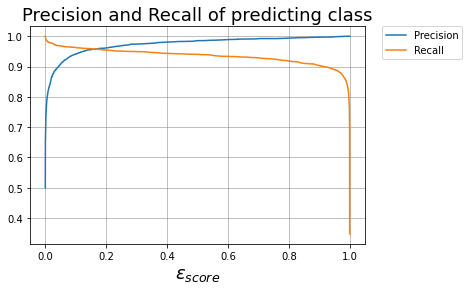

In [26]:
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot as plt


precision, recall, thresholds = precision_recall_curve(all_y_true.cpu(), all_y_hat.cpu())
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.xlabel("$\epsilon_{score}$",fontsize=18)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.grid(visible=True, which="both", axis="both", color='gray', linestyle='-', linewidth=0.5)
plt.title('Precision and Recall of predicting class', fontsize=18)
plt.show()

Precision at threshold $\epsilon_{score}$=0.8

In [27]:
import torchmetrics as m

precision = m.Precision(threshold=0.8).to(device)
precision(all_y_hat, all_y_true).item()

0.9937338829040527

## Classify block relationship with score

In [25]:
def ranking_score(inference, epsilon_score = 0.8, epsilon_covery = 0.5):
    """
    epsilon_score: float, default 0.8
        Value at which, precision(y_hat >= epsilon_score) ~ 1
    epsilon_covery: float, default 0.5
        Because we would look into column and row if the detection is very sparse
    """
    y_score_matrix = inference['y_score_matrix']

    # We define a covery of positive pair
    # If this covery is very sparse, we enter in a special case, where we want to look at column and row
    pair_mask = (y_score_matrix >= epsilon_score).type(torch.float)

    relation_type = None
    
    if (y_score_matrix.size(0) > 1 or y_score_matrix.size(1) > 1) and pair_mask.mean() < epsilon_covery:
        # Detect relationship as row or column if they have more than 1 row and more than 1 column
        inference_col = torch.prod(pair_mask, 0)
        inference_row = torch.prod(pair_mask, 1)

        if inference_col.any().item(): 
            relation_type = 'column'
            masking_score = y_score_matrix.mul(inference_col.unsqueeze(0))
            ranking_score = masking_score[masking_score > 0].mean()

        if inference_row.any().item():
            if relation_type is not None: 
                relation_type += '_row'
            else:
                relation_type = 'row'
            
            masking_score = y_score_matrix.mul(inference_row.unsqueeze(1))
            ranking_score = masking_score[masking_score > 0].mean()
            
        if relation_type is None:
            ranking_score = y_score_matrix.mul(y_score_matrix > epsilon_score).mean()
            relation_type = 'neutral'
    
    else: 
        # Compute the average score.
        # Later: reweight the score with number of sentence
        # Later: reweight (or not) the score with sentence length (see if the quality depend on sentence length)
        relation_type = 'dense'
        ranking_score = y_score_matrix.mul(pair_mask).mean()
        relation_type = 'dense' if ranking_score > 0.8 else 'neutral'
    
    return {
        'ranking_score' : ranking_score.item(),
        'type' : relation_type,
        'pair_mask': pair_mask,
    }

In [26]:
import seaborn as sns
from matplotlib import pyplot as plt

def visualize_heatmap(y_score_matrix, source_label=None, target_label=None, threshold=None):
    """Visualize heat map for the score matrix

    Parameters
    ----------
    y_score_matrix : list of list
        matrix consisting of predicting score        
    """
    if threshold is not None:
        y_score_matrix = y_score_matrix > threshold
    ax = sns.heatmap(y_score_matrix, annot=True, vmin=0, vmax=1, cmap="crest")

    ax.set_ylabel(source_label or 'Source', fontsize = 16)
    ax.set_xlabel(target_label or 'Target', fontsize = 16)
    plt.show()

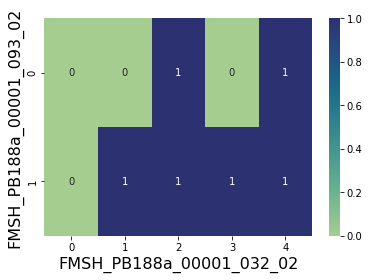

{'ranking_score': 0.5171533823013306,
 'type': 'neutral',
 'pair_mask': tensor([[0., 0., 1., 0., 1.],
         [0., 1., 1., 1., 1.]])}

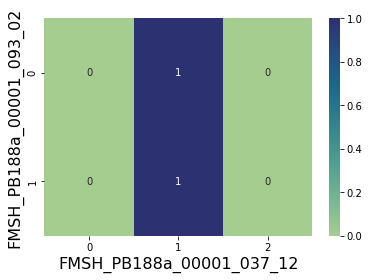

{'ranking_score': 0.8691788911819458,
 'type': 'column',
 'pair_mask': tensor([[0., 1., 0.],
         [0., 1., 0.]])}

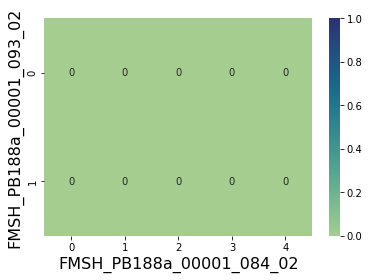

{'ranking_score': 0.0,
 'type': 'neutral',
 'pair_mask': tensor([[0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]])}

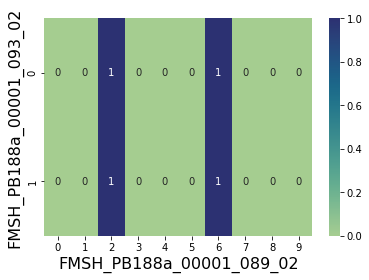

{'ranking_score': 0.8675836324691772,
 'type': 'column',
 'pair_mask': tensor([[0., 0., 1., 0., 0., 0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0., 0., 1., 0., 0., 0.]])}

In [27]:
N_MAX = 3
cpt = 0

for idx, link in df_link.iterrows():
    uid_source = link['source.bloc.uid']
    uid_target = link['target.bloc.uid']
    
    try:
        n_source = df_block.loc[uid_source, 'n_sent']
        n_target = df_block.loc[uid_target, 'n_sent']
    except KeyError:
        # The bloc does not exist yet in mongodb, skip this!
        continue
    
    if n_source > 1 and n_target > 1:
        norm_block_source = get_block(df_block, uid_source)
        norm_block_target = get_block(df_block, uid_target)
        
        inference = inference_block(norm_block_source, norm_block_target, dm, model)
        
        visualize_heatmap(inference['y_score_matrix'], uid_source, uid_target, threshold=0.8)
        
        ranking_output = ranking_score(inference)
        
        display(ranking_output)
        cpt += 1
        if cpt > N_MAX:
            break

In [28]:
from modules import rescale

def aggegrate_attention(inference, ranking_output):
    """
    Aggregate different attention together
    """
    
    y_score_matrix = inference['y_score_matrix']
    pair_mask = ranking_output['pair_mask']
    padding_mask = inference['padding_mask']
    masked_score = y_score_matrix * pair_mask
    agg_attention = dict()
    
    for side, attention in inference['attention'].items():
        dim_side = 1 if side == 'source' else 0
        
        attention = inference['attention'][side]
        
        # normalize masked_score along target/source
        normalized_score = masked_score / (masked_score.sum(dim=dim_side, keepdim=True) + 1e-30)
        
        attention = attention.mul(normalized_score.unsqueeze(-1))
        
        agg_attention[side] = attention.sum(dim=dim_side)
        
        agg_attention[side] = rescale(agg_attention[side], ~padding_mask[side])
        
        agg_attention[side] = [torch.masked_select(a, m.type(torch.bool)).tolist() for a, m in zip(agg_attention[side], padding_mask[side])]
        
    return agg_attention

In [29]:
def extract_string_id(block_alto_id, block_attention):
    """
    get attention value for corresponding string alto ids
    
    block_alto_id : list of list
        list of ids sentence. Ids sentence = a list of alto ids
        
    block_attention : list of list
        list of attention sentence. Attention sentence = a list of attention along s
    """
    
    assert len(block_alto_id) == len(block_attention), f'Incompatible number of sentence. len(block_alto_id)={len(block_alto_id)}, len(block_attention)={len(block_attention)}'
    
    attention_values = [
            {
                'alto_id' : alto_id,
                'attention' : a_hat,
            } for sentence_alto_id, sentence_attention in zip(block_alto_id, block_attention) 
            for alto_id, a_hat in zip(sentence_alto_id, sentence_attention)  if a_hat > 0
         ]
    
    return attention_values



Demonstration of explanation between 2 blocks

In [96]:
model.eval()

link = df_link.iloc[270]

source_revue_id = link['source.revue.id']
source_article_id = link['source.article.id']
source_page_id = link['source.page.id']
source_block_id = link['source.bloc.id']
link_type = link['link.type']

####################
# INFERENCE ON LINK
####################
# get uid
block_uid = { side: link[f'{side}.bloc.uid'] for side in ['source', 'target']}

# get token 'norm' (aka. normalized tokens for model)
block_norm = { side : get_block(df_block, block_uid[side]) for side in ['source', 'target'] }
# batched inference from gpu model
inference = inference_block(block_norm['source'], block_norm['target'], dm, model)
# aggregate score to form a ranking score + interpretation
ranking_output = ranking_score(inference)
# aggregate attention maps
block_attentions = aggegrate_attention(inference, ranking_output)


html = '<table><thead><tr><th>Block source</th> <th>Block target</th> <th>Score</th> <th>Type</th> </tr></thead>'

html += '<tbody>'
html += '<tr>'

block_form = get_block(df_block, block_uid['source'],'form')
tokens = [token for sentence in block_form for token in sentence]
attention = [att for sentence in block_attentions['source'] for att in sentence]
html += '<td>'+ highlight(tokens, attention)+ '</td>'

block_form = get_block(df_block, block_uid['target'],'form')
tokens = [token for sentence in block_form for token in sentence]
attention = [att for sentence in block_attentions['target'] for att in sentence]
html += '<td>'+ highlight(tokens, attention)+ '</td>'

html += '<td>'+ str(round(ranking_output['ranking_score'],3)) +'</td>'

html += '<td>'+ ranking_output['type'] +'</td>'

html += '</tr>'
    
html += '</tbody></table>'
display(HTML(html))

print('QA source:')
print(link['reason.question_source'], link['reason.answer_source'])
print('QA target:')
print(link['reason.question_target'], link['reason.answer_target'])

QA source:
Que doit faire la L.C.Y. ? lutter sans cesse contre les tentatives de perpétuer les anciens rapports dans tous les secteurs de la vie et du travail de la société et surtout dans ses propres rangs
QA target:
Que doivent faire les forces sociales qui se tiennent sur des positions idéologiques et antagonistes ? renoncer


Generate explanations from QA links

In [ ]:
from tqdm import tqdm

model.eval()

for idx_link, link in tqdm(df_link[1400:].iterrows(), total=len(df_link), desc='Generate NLI links'):

    source_revue_id = link['source.revue.id']
    source_article_id = link['source.article.id']
    source_page_id = link['source.page.id']
    source_block_id = link['source.bloc.id']
    link_type = link['link.type']

    ####################
    # INFERENCE ON LINK
    ####################
    # get uid
    block_uid = { side: link[f'{side}.bloc.uid'] for side in ['source', 'target']}
    
    skip=False
    # check if uid not exist in df_block: SKIP
    for side, uid in block_uid.items():
        if uid not in df_block.index:
            #log.warning(f'Block uid {uid} ({side}) does not exist in Mongo')
            skip = True
    if skip: 
        continue
    
    # get token 'norm' (aka. normalized tokens for model)
    block_norm = { side : get_block(df_block, block_uid[side]) for side in ['source', 'target'] }
    # batched inference from gpu model
    inference = inference_block(block_norm['source'], block_norm['target'], dm, model)
    # aggregate score to form a ranking score + interpretation
    ranking_output = ranking_score(inference)
    # aggregate attention maps
    block_attentions = aggegrate_attention(inference, ranking_output)
    # extract attention value for corresponding attention ids
    attention_alto_ids = {}
    for side in ['source', 'target']:
        block_alto_ids = get_block(df_block, block_uid[side], 'alto_id')
        attention_alto_ids[side] = extract_string_id(block_alto_ids, block_attentions[side])

    ##########################
    # WRITE INFERENCE TO FILE
    ##########################   
    # Create our folder
    link_inference_path = path.join(COLLECTION_PATH, source_revue_id, source_article_id, 'links_inference')
    os.makedirs(link_inference_path, exist_ok = True)
    filepath = path.join(link_inference_path, source_page_id + '.json')

    # Link information here
    target_block = {
        'textblock_id': link['target.article.id'] + '|' + link['target.bloc.id'], # $persee_id$|$fmsh_id$|block_$id$
        'article_id': link['target.article.id'],
        'page_id': link['target.page.id'],
        'block_id' : link['target.bloc.id'],
        'reason' : {
            'score' : ranking_output['ranking_score'], # ranking score
            'type': ranking_output['type'],
            'aggregated_attention' : attention_alto_ids,
            'inference_pairs' : [], # ranking sentences pairs (sorted) + attention + predcition_certainty

        }
    }
    
    if path.exists(filepath):

        # If the files exists, update the recommending block
        with open(filepath, 'r') as f:
            content = json.load(f)


        # Query all the source block in textBlockList. If not found, add new one
        text_block_list = content['page']['textBlockList']
        added = False

        for source_block in text_block_list:

            # source block exist, add new target block
            if source_block['id'] == source_block_id: 
                target_blocks = source_block.get(link_type, []) # if link type not exist, create empty list
                target_blocks.append(target_block)
                source_block[link_type] = target_blocks
                added = True
                break

        # source block does not exist, create new source block and add first target block
        if not added: 
            text_block_list.append({
                'id': source_block_id,
                link_type : [
                    target_block,
                ]
            })


    else :
        # If the files does not exist, create a new attention ranking
        content = {
        "method": "inference_langue_naturel",
        'page': {
            'textBlockList' : [
                {
                    'id': source_block_id,
                    link_type : [
                        target_block
                    ]
                },        

            ]
        }
    }
    
    # Save content to file
    with open(filepath, 'w') as f:
        json.dump(content, f, indent=4)

Generate NLI links:   3%|█████                                                                                                                                                                            | 31882/1120718 [2:16:23<22:27:59, 13.46it/s]

## Attention plausibility

### Est-ce que les cartes d’attention de la même phrase (dans des différentes paires) resteront inchangées ?

In [ ]:
from data_module.archival_module import ArchivalNLIDM
from model_module.lstm.archival_lstm_module import ArchivalLstmModule
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

###############
# PREPARE DATA
###############
dm = ArchivalNLIDM(cache_path=DATA_CACHE, batch_size=16)
dm.prepare_data()

###############
# MODEL MODULE
###############

# model's parameters (could be changed in other versions)
MODEL_NAME = 'run=6_vector=0_lentropy=0.05'
m_kwargs = dict(
    n_context=1, 
    d_embedding=300
)

# leave the default ones
model = ArchivalLstmModule(cache_path=MODEL_CACHE,
    mode='exp',
    vocab=dm.vocab,
    concat_context=True,
    data='archival',
    num_class=dm.num_class, **m_kwargs)

ckpt_path = path.join(LOG_PATH, 'archival', MODEL_NAME, 'checkpoints', 'best.ckpt')
if torch.cuda.is_available():
    checkpoint = torch.load(ckpt_path)
else:
    checkpoint = torch.load(ckpt_path, map_location=torch.device('cpu'))
    
model.to(device)
model.load_state_dict(checkpoint['state_dict'])
model.eval()

print('Model is in cuda: ',next(model.parameters()).is_cuda)

### What is the highlighted words in attention map ?

In [30]:
def binarize(alpha, masss_threshold=0.8):
    
    # Sort the distribution tensor in descending order
    sorted_alpha, indices = torch.sort(alpha, descending=True)
    # Compute the cumulative sum of the sorted tensor
    cumsum_alpha = torch.cumsum(sorted_alpha, dim=0)
    # Find the index of the first element whose cumulative sum is >= 0.8
    index = torch.argmax((cumsum_alpha >= masss_threshold).int(), dim=0)
    # Create a binary mask with True for the elements with cumsum_alpha >= 0.8
    b = torch.zeros_like(alpha, dtype=torch.int)
    b[indices[:index+1]] = 1
    return b

In [36]:
from tqdm.auto import tqdm
from modules import highlight

dm.setup('test')
attended_word_frequency = {'premise': dict(), 'hypothesis': dict()}
df_inference = []

for batch in tqdm(dm.test_dataloader(), desc='Test'):
    y_true = batch['y_true'].to(device)
    with torch.no_grad():
        y_hat, a_hat = model(premise_ids=batch['premise_ids'].to(device), 
            hypothesis_ids=batch['hypothesis_ids'].to(device), 
            premise_padding=batch['padding_mask']['premise'].to(device),
            hypothesis_padding=batch['padding_mask']['hypothesis'].to(device))
        
    y_hat = y_hat.softmax(-1)    
    y_hat = y_hat[:, 1]
    
    a_hat = {s : alpha.softmax(1) for s, alpha in a_hat.items() }
    a_hat['hypothesis'] = a_hat['hypothesis'].softmax(dim=1)
        
    for i in range(len(y_hat)):
        df_inference.append({
            'premise': highlight(batch['premise.form'][i], a_hat['premise'][i]),
            'hypothesis': highlight(batch['hypothesis.form'][i], a_hat['hypothesis'][i]),
            'y_hat': y_hat[i].item(),
            'y_true': int(batch['y_true'][i]),
        })
    
    for s, alpha in a_hat.items():
        # Get a_hat from only possitive example
        alpha = alpha[y_true == 1,:]
        # binarize on alpha
        alpha = binarize(alpha)
        
        tokens = batch[s+'.norm']
        for word_vector, alpha_vector in zip(tokens, alpha):
            for w, a in zip(word_vector, alpha_vector):
                if a > 0: 
                    attended_word_frequency[s][w] = attended_word_frequency[s].get(w, 0) +1
        
        a_hat[s] = alpha
        

        
df_inference = pd.DataFrame(df_inference)

14-04-2023 14:23:26 |     INFO   dataset.py:__init__:87  Load dataset from /srv/tempdd/dunguyen/RUNS/dataset/archival/v1/test.json


Test:   0%|          | 0/473 [00:01<?, ?it/s]

TypeError: only integer tensors of a single element can be converted to an index

In [ ]:
for side, frequency in attended_word_frequency.items():
    sorted_frequency = dict(sorted(frequency.items(), key=lambda x: x[1], reverse=True))
    attended_word_frequency[side] = sorted_frequency

In [ ]:
n = 20

for side, frequency in attended_word_frequency.items():
    print(str(n)+' words most attended in '+ side)
    print()
    top_n = dict(list(frequency.items())[:n])
    df = pd.DataFrame(list(frequency.items()), columns=['Word', 'Count'])
    df = df[df['Count'] > 1]
    display(df.transpose())
    print('=20')

In [ ]:
for side, frequency in attended_word_frequency.items():
    top_n = dict(list(frequency.items())[:n])
    df = pd.DataFrame(list(frequency.items()), columns=['Word', 'Count'])
    df = df[df['Count'] > 1]
    display(df[50:].transpose())
    print('=20')

In [ ]:
for side, frequency in attended_word_frequency.items():
    top_n = dict(list(frequency.items())[:n])
    df = pd.DataFrame(list(frequency.items()), columns=['Word', 'Count'])
    df = df[df['Count'] > 1]
    display(df[50:].transpose())
    print('=20')

#### Test on Archival study subset : on work



In [ ]:
## Server parameters
ON_IGRIDA = True

if ON_IGRIDA:
    SERVER_DIR = '/srv/tempdd/dunguyen/RUNS'
else:
    SERVER_DIR = '/Users/dunguyen/Projects/IGRIDA/historic/2023-02-23/archival'

LOG_PATH = path.join(SERVER_DIR, 'logs')
DATA_CACHE = path.join(SERVER_DIR, 'dataset')
#MODEL_CACHE = path.join(SERVER_DIR, 'models')

## Model parameters (the model inference has already been done in IGRIDA. In this notebook we retrieve only its inference)
MODEL_NAME = 'run=6_vector=0_lentropy=0.05'

In [ ]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

POST_PROCESS_INFERENCE_PATH = path.join(LOG_PATH, 'archival', MODEL_NAME, 'predictions','clean_inference_sentence_pairs_v2.json')
INFERENCE_PATH = path.join(LOG_PATH, 'archival', MODEL_NAME, 'predictions','batch_inference_sentence_pairs_v2.json')

# load inference file
if path.exists(POST_PROCESS_INFERENCE_PATH):
    inference_sentences = pd.read_json(POST_PROCESS_INFERENCE_PATH, encoding='utf-8')
    print(f'Load inference_sentences from {POST_PROCESS_INFERENCE_PATH}')
else:
    
    inference_sentences = pd.read_json(INFERENCE_PATH, orient='records', encoding='utf-8')

    def remove_mask(row):
        for side in ['premise', 'hypothesis']:
            padding_mask = np.array(row[f'padding_mask.{side}'])

            a_hat = np.array(row[f'a_hat.{side}'])
            a_hat = a_hat[~padding_mask]
            row[f'a_hat.{side}'] = a_hat.tolist()

            ids = np.array(row[f'{side}_ids'])
            ids = ids[~padding_mask]
            row[f'{side}_ids'] = ids.tolist()
        return row

    if 'padding_mask.premise' in inference_sentences.columns:
        tqdm.pandas(desc='remove_mask')
        inference_sentences = inference_sentences.progress_apply(remove_mask,axis=1)
        inference_sentences.drop(columns=['padding_mask.premise', 'padding_mask.hypothesis'], inplace=True)
    
    with open(POST_PROCESS_INFERENCE_PATH, 'w', encoding='utf-8') as f:
        inference_sentences.to_json(f, force_ascii=False)
        print(f'Save inference_sentences to {POST_PROCESS_INFERENCE_PATH}')
        
inference_sentences

In [ ]:
inference_sentences = inference_sentences[~inference_sentences['source.sentence.id'].isnull()].reset_index(drop=True)

In [ ]:
inference_sentences['premise.norm']

In [ ]:
def stacks(series):
    return [x for x in series]

def get_first(series):
    return series.iloc[0]

inference_group_source = inference_sentences.groupby([inference_sentences['source.sentence.uid']], as_index=False).agg({
    'a_hat.premise': stacks,
    'y_score': stacks,
    'premise.norm': get_first
})

inference_group_source